In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [3]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.fc2 = torch.nn.Linear(512, 64)
        self.fc3 = torch.nn.Linear(64, 16)
        self.fc4 = torch.nn.Linear(16, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 16)
        self.fc2 = torch.nn.Linear(16, 64)
        self.fc3 = torch.nn.Linear(64, 512)
        self.fc4 = torch.nn.Linear(512, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))  # -1～1に変換
        return x

class AutoEncoder(torch.nn.Module):
    def __init__(self, org_size):
        super().__init__()
        self.enc = Encoder(org_size)
        self.dec = Decoder(org_size)
    def forward(self, x):
        x = self.enc(x)  # エンコード
        x = self.dec(x)  # デコード
        return x

In [4]:
#dataset loading
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
mean = (0.5,)
std = (0.5,)

dataset = ImageFolder( "../data/GAN_weak", transform = ImageTransform(mean, std))
train_size = int(0.8 * len(dataset))
indices = np.arange(len(dataset))
train_dataset = torch.utils.data.Subset(dataset, indices[:train_size])
val_dataset = torch.utils.data.Subset(dataset, indices[train_size:])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=True, num_workers=0)

/home/hoge/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


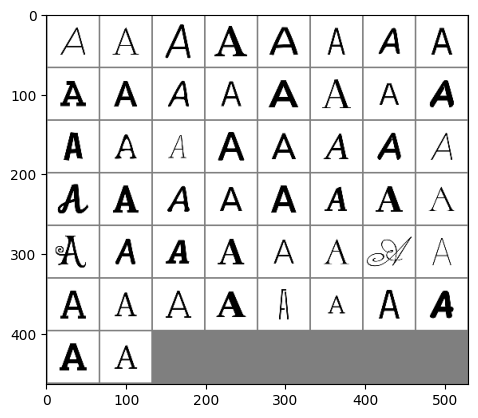

In [5]:
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

iterator = iter(train_loader)
x, _ = next(iterator)
imshow(x)

In [6]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='src/googlefonts.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

In [7]:
def train_val(net, criterion, optimizer, train_loader, val_loader):
    train_losses = []
    val_losses = []
    output_and_label = []
    earlystopping = EarlyStopping(patience=20, verbose=True)

    for epoch in range(1, 10000):
        print(f'epoch: {epoch}, ', end='')
        net.train()
        train_loss = 0
        for counter, (img, _) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            img = img.reshape(-1, input_size)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= counter
        train_losses.append(train_loss)

        print('training loss:', train_loss)

        net.eval()
        val_loss = 0
        with torch.no_grad():
            for counter, (img, _) in enumerate(val_loader, 1):
                img = img.reshape(-1, input_size)
                output = net(img)
                val_loss += criterion(output, img).item()
        val_loss /= counter
        val_losses.append(val_loss)
        # print('loss:', val_loss)
        output_and_label.append((output, img))
        earlystopping(val_loss, net) #callメソッド呼び出し
        if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
            print("Early Stopping!")
            break

    return output_and_label, train_losses, val_losses

input_size = 64 * 64
net = AutoEncoder(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
EPOCHS = 100

output_and_label, train_losses, val_losses = train_val(net, criterion, optimizer, train_loader, val_loader)

epoch: 1, training loss: 0.9885239660739898
Validation loss decreased (inf --> 0.986456).  Saving model ...
epoch: 2, training loss: 0.9845620095729828
Validation loss decreased (0.986456 --> 0.982621).  Saving model ...
epoch: 3, training loss: 0.9806412696838379
Validation loss decreased (0.982621 --> 0.978644).  Saving model ...
epoch: 4, training loss: 0.9766863942146301
Validation loss decreased (0.978644 --> 0.974600).  Saving model ...
epoch: 5, training loss: 0.9726535618305207
Validation loss decreased (0.974600 --> 0.970429).  Saving model ...
epoch: 6, training loss: 0.9684902906417847
Validation loss decreased (0.970429 --> 0.966279).  Saving model ...
epoch: 7, training loss: 0.9641050577163697
Validation loss decreased (0.966279 --> 0.961677).  Saving model ...
epoch: 8, training loss: 0.9594688296318055
Validation loss decreased (0.961677 --> 0.956691).  Saving model ...
epoch: 9, training loss: 0.9544856727123261
Validation loss decreased (0.956691 --> 0.951608).  Savin

In [15]:
from torchvision.utils import make_grid

/tmp/ipykernel_11332/674498900.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(24, 2, i*2+1)
/tmp/ipykernel_11332/674498900.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4,26))


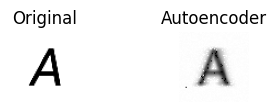

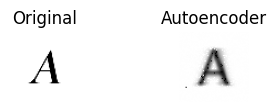

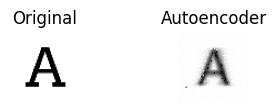

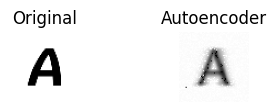

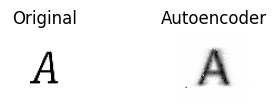

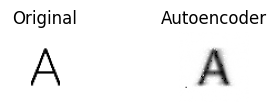

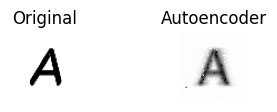

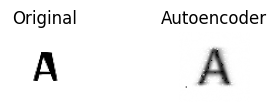

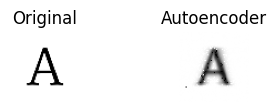

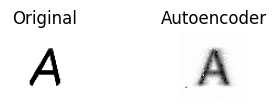

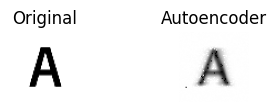

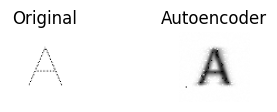

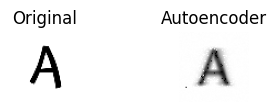

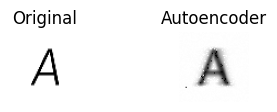

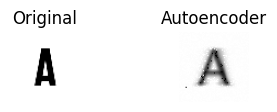

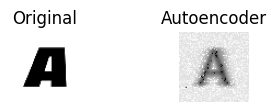

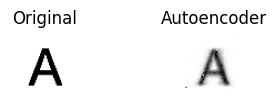

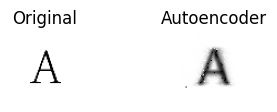

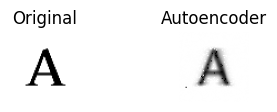

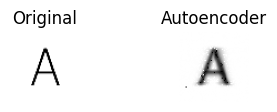

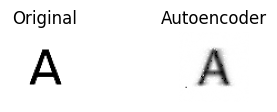

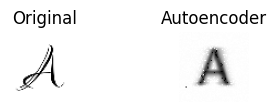

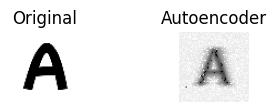

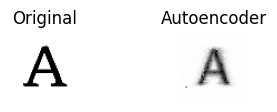

In [51]:
titles = {0: 'Original', 1: 'Autoencoder'}
for i, (img, r_img) in enumerate(zip(output_and_label[105][1], output_and_label[105][0])):
    image = img.view(64, 64).detach().cpu().numpy()
    r_image = r_img.view(64, 64).detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(4,26))
    plt.subplot(24, 2, i*2+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off'), plt.title(titles[0])
    plt.subplot(24, 2, i*2+2)
    plt.imshow(r_image, cmap='gray')
    plt.axis('off'), plt.title(titles[1])
plt.show()